In [45]:
import pandas as pd
import seaborn as sns
import duckdb
import utils 
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
import matplotlib.pyplot as plt



In [46]:
con = duckdb.connect("data.db")


In [47]:
oecd = con.sql("SELECT * FROM oecd").df() 
ecb = con.sql("SELECT * FROM ecb").df()         # Pandas DataFrame
eurostat = con.sql("SELECT * FROM eurostat").df()         # Pandas DataFrame
world_b = con.sql("SELECT * FROM world_bank").df()         # Pandas DataFrame


In [48]:
oecd.dtypes

DATE      object
GEO       object
LTIR     float64
STIR     float64
IIR      float64
CBAR     float64
UEMPR    float64
dtype: object

# **DATA PREPARATION**

- There is two different country abbrevation thorugh the data. In this section that is fixed to three letter abrevation and 
- the data merged via abbrevations and date 
- analyzed missing values and france selected as main data becasue it has the most non-null values

## Filtering

In [49]:
import pycountry

def convert_alpha2_to_alpha3(code):
    if not code or not isinstance(code, str):
        return code
    try:
        return pycountry.countries.get(alpha_2=code.upper()).alpha_3
    except:
        return code  # return original value if not ISO

    
eurostat['GEO'] = eurostat['GEO'].apply(convert_alpha2_to_alpha3)
eurostat['GEO'].unique()


array(['BRA', 'CAN', 'CHN', 'DEU', 'FRA', 'IDN', 'IND', 'ITA', 'JPN',
       'KOR', 'MEX', 'RUS', 'USA', 'ZAF', 'ARG', 'FIN', 'SAU', 'G20',
       'TUR', 'UK', 'BEL', 'EST', 'LTU', 'EA19', 'EU28', 'EU27_2020',
       'AUT', 'BGR', 'CHE', 'CYP', 'CZE', 'DNK', 'EA20', 'EL', 'ESP',
       'HRV', 'HUN', 'IRL', 'LUX', 'LVA', 'MNE', 'MLT', 'NLD', 'NOR',
       'POL', 'PRT', 'ROU', 'SRB', 'SVN', 'SVK', 'ALB', 'BIH', 'MKD',
       'SWE'], dtype=object)

In [50]:
import pandas as pd

def compare_columns(df1, df2, column_name):
    """
    Compare columns between two DataFrames and print common and uncommon columns.

    Parameters:
    - df1, df2: pandas DataFrames to compare
    """
    cols1 = set(df1[column_name])
    cols2 = set(df2[column_name])

    common = cols1 & cols2
    only_in_df1 = cols1 - cols2
    only_in_df2 = cols2 - cols1

    print("✅ Common columns:")
    print(sorted(common))
    print("\n🟥 Only in first DataFrame:")
    print(sorted(only_in_df1))
    print("\n🟦 Only in second DataFrame:")
    print(sorted(only_in_df2))

    return {
        "common": common,
        "only_in_df1": only_in_df1,
        "only_in_df2": only_in_df2
    }


In [51]:
col_names = compare_columns(oecd,eurostat,"GEO")

✅ Common columns:
['AUT', 'BEL', 'BGR', 'BRA', 'CAN', 'CHE', 'CHN', 'CZE', 'DEU', 'DNK', 'EA19', 'EA20', 'ESP', 'EST', 'EU27_2020', 'FIN', 'FRA', 'HRV', 'HUN', 'IDN', 'IND', 'IRL', 'ITA', 'JPN', 'KOR', 'LTU', 'LUX', 'LVA', 'MEX', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'RUS', 'SVK', 'SVN', 'SWE', 'TUR', 'USA', 'ZAF']

🟥 Only in first DataFrame:
['A5M', 'AUS', 'CHL', 'COL', 'CRI', 'G7', 'GBR', 'GRC', 'ISL', 'ISR', 'NZL', 'OECD', 'OECDE', 'OECDXEA']

🟦 Only in second DataFrame:
['ALB', 'ARG', 'BIH', 'CYP', 'EL', 'EU28', 'G20', 'MKD', 'MLT', 'MNE', 'SAU', 'SRB', 'UK']


In [52]:
def filter_geo(df, geo):
    """
    Filters a DataFrame by one or more GEO codes.

    Parameters:
    - df: pandas DataFrame
    - geo: a single GEO string or a list of GEO strings

    Returns:
    - Filtered DataFrame
    """
    if isinstance(geo, (list, tuple, set)):
        return df[df["GEO"].isin(geo)]
    else:
        return df[df["GEO"] == geo]


In [53]:
import pandas as pd

def null_counts_by_category(df, category_col, date_col='DATE'):
    """
    Calculates number of nulls and percentage of nulls in each column,
    grouped by values in a category column.

    Parameters:
    - df: pandas DataFrame
    - category_col: column name to group by (as string)
    - date_col: column used to count total entries per category (default='DATE')

    Returns:
    - DataFrame: index = category values, columns = original columns (with count and percentage),
                 plus 'avg_perct' column, sorted by 'avg_perct'.
    """
    if category_col not in df.columns:
        raise ValueError(f"Column '{category_col}' not found in DataFrame.")

    # Count unique occurrences for each category (denominator for %)
    total_counts = df.groupby(category_col)[date_col].nunique()

    # Count nulls
    null_counts = df.groupby(category_col).apply(lambda group: group.isnull().sum())
    null_counts = null_counts.drop(columns=[category_col], errors="ignore")

    # Calculate percentage of nulls for each column
    percentage_nulls = null_counts.div(total_counts, axis=0) * 100
    percentage_nulls = percentage_nulls.round(2).astype(str) + '%'

    # Calculate average percentage per row (as float)
    avg_perct = null_counts.div(total_counts, axis=0).mean(axis=1) * 100

    # Combine counts and percentages with avg_perct
    result = pd.concat([null_counts, percentage_nulls.add_suffix('_%')], axis=1)
    result['avg_perct'] = avg_perct.round(2)

    # Sort by average percentage
    result = result.sort_values(by='avg_perct')

    return result

In [54]:
null_counts_by_category(filter_geo(oecd,col_names["common"]),"GEO")

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_35711/1046894067.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  null_counts = df.groupby(category_col).apply(lambda group: group.isnull().sum())


,DATE,LTIR,STIR,IIR,CBAR,UEMPR,DATE_%,LTIR_%,STIR_%,IIR_%,CBAR_%,UEMPR_%,avg_perct
GEO,,,,,,,,,,,,,
LTU,0,33,9,9,38,1,0.0%,10.22%,2.79%,2.79%,11.76%,0.31%,4.64
CZE,0,87,0,0,25,1,0.0%,22.54%,0.0%,0.0%,6.48%,0.26%,4.88
USA,0,0,135,15,82,21,0.0%,0.0%,15.64%,1.74%,9.5%,2.43%,4.89
SVK,0,58,5,0,42,27,0.0%,16.48%,1.42%,0.0%,11.93%,7.67%,6.25
FIN,0,13,0,144,11,13,0.0%,2.84%,0.0%,31.44%,2.4%,2.84%,6.59
HUN,0,97,28,12,26,61,0.0%,23.66%,6.83%,2.93%,6.34%,14.88%,9.11
KOR,0,129,12,12,108,0,0.0%,30.57%,2.84%,2.84%,25.59%,0.0%,10.31
CAN,0,0,12,240,301,0,0.0%,0.0%,1.43%,28.5%,35.75%,0.0%,10.95
ESP,0,79,43,0,158,155,0.0%,12.72%,6.92%,0.0%,25.44%,24.96%,11.67


In [55]:
null_counts_by_category(filter_geo(eurostat,col_names["common"]),"GEO")

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_35711/1046894067.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  null_counts = df.groupby(category_col).apply(lambda group: group.isnull().sum())


,DATE,Retail_Volume,CPI,DATE_%,Retail_Volume_%,CPI_%,avg_perct
GEO,,,,,,,
DEU,0,2,0,0.0%,0.53%,0.0%,0.18
EU27_2020,0,2,0,0.0%,0.66%,0.0%,0.22
FRA,0,62,0,0.0%,16.58%,0.0%,5.53
ITA,0,74,0,0.0%,19.79%,0.0%,6.60
TUR,0,168,0,0.0%,48.28%,0.0%,16.09
KOR,0,374,0,0.0%,100.0%,0.0%,33.33
LTU,0,0,324,0.0%,0.0%,100.0%,33.33
LUX,0,0,300,0.0%,0.0%,100.0%,33.33
LVA,0,0,300,0.0%,0.0%,100.0%,33.33


In [56]:

df_merged_0 = filter_geo(eurostat,["FRA"]).merge(filter_geo(oecd,["FRA"]), on="DATE", how="outer")
df_merged_0

,DATE,GEO_x,Retail_Volume,CPI,GEO_y,LTIR,STIR,IIR,CBAR,UEMPR
0,1955-01,NaN,NaN,NaN,FRA,NaN,NaN,3.270000,NaN,NaN
1,1955-02,NaN,NaN,NaN,FRA,NaN,NaN,3.250000,NaN,NaN
2,1955-03,NaN,NaN,NaN,FRA,NaN,NaN,3.280000,NaN,NaN
3,1955-04,NaN,NaN,NaN,FRA,NaN,NaN,3.230000,NaN,NaN
4,1955-05,NaN,NaN,NaN,FRA,NaN,NaN,3.270000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
837,2024-10,FRA,-0.5,0.3,FRA,2.99,3.166609,3.371394,-0.154174,7.3
838,2024-11,FRA,0.2,-0.1,FRA,3.09,3.006762,3.164967,-0.386029,7.3
839,2024-12,FRA,-0.7,0.2,FRA,3.01,2.816091,3.102686,-0.372024,7.3
840,2025-01,FRA,-0.1,-0.2,FRA,3.32,2.703130,2.918839,0.575679,7.3


In [57]:
df_merged = df_merged_0.merge(world_b, on="DATE", how="outer")
df_merged

,DATE,GEO_x,Retail_Volume,CPI,GEO_y,LTIR,STIR,IIR,CBAR,UEMPR,POP_y
0,1955-01,NaN,NaN,NaN,FRA,NaN,NaN,3.270000,NaN,NaN,NaN
1,1955-02,NaN,NaN,NaN,FRA,NaN,NaN,3.250000,NaN,NaN,NaN
2,1955-03,NaN,NaN,NaN,FRA,NaN,NaN,3.280000,NaN,NaN,NaN
3,1955-04,NaN,NaN,NaN,FRA,NaN,NaN,3.230000,NaN,NaN,NaN
4,1955-05,NaN,NaN,NaN,FRA,NaN,NaN,3.270000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
837,2024-10,FRA,-0.5,0.3,FRA,2.99,3.166609,3.371394,-0.154174,7.3,NaN
838,2024-11,FRA,0.2,-0.1,FRA,3.09,3.006762,3.164967,-0.386029,7.3,NaN
839,2024-12,FRA,-0.7,0.2,FRA,3.01,2.816091,3.102686,-0.372024,7.3,NaN
840,2025-01,FRA,-0.1,-0.2,FRA,3.32,2.703130,2.918839,0.575679,7.3,NaN


### Handling missing values

In [58]:
import pandas as pd

# Assume df is your DataFrame and 'date' is your date column
df = df_merged.sort_values('DATE').reset_index(drop=True)  # Make sure it's sorted by date
# Identify numeric columns (excluding date)
numeric_cols = df.select_dtypes(include='number').columns

# Create a mask where all numeric values are NaN
all_nan_mask = df[numeric_cols].isnull().any(axis=1)
# Find first and last index where not all numeric values are NaN
first_valid_idx = df[~all_nan_mask].index[0]
last_valid_idx = df[~all_nan_mask].index[-1]

# Trim DataFrame from first to last valid index
df_trimmed = df.loc[first_valid_idx:last_valid_idx].copy()

# Fill missing values between using interpolation (or any other method)
df_filled = df_trimmed.copy()
df_filled[numeric_cols] = df_trimmed[numeric_cols].interpolate(method='linear')

# Optional: fill remaining nulls if interpolation didn't cover all
df_filled[numeric_cols] = df_filled[numeric_cols].fillna(method='bfill').fillna(method='ffill')


/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_35711/2430720086.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[numeric_cols] = df_filled[numeric_cols].fillna(method='bfill').fillna(method='ffill')


In [59]:
df_filled

,DATE,GEO_x,Retail_Volume,CPI,GEO_y,LTIR,STIR,IIR,CBAR,UEMPR,POP_y
529,1999-02,FRA,1.7,0.4,FRA,3.9377,3.093400,3.118000,0.030459,12.0,6.053671e+07
530,1999-03,FRA,0.8,0.3,FRA,4.1367,3.046696,2.925200,-0.182699,11.8,6.057143e+07
531,1999-04,FRA,-0.4,0.3,FRA,3.9893,2.696455,2.709100,-0.091516,11.7,6.060615e+07
532,1999-05,FRA,0.7,0.0,FRA,4.1686,2.578952,2.551000,0.030533,11.5,6.064088e+07
533,1999-06,FRA,0.0,0.0,FRA,4.4893,2.626682,2.563200,0.137358,11.4,6.067560e+07
...,...,...,...,...,...,...,...,...,...,...,...
811,2022-08,FRA,1.3,0.5,FRA,1.6900,0.394739,-0.094652,0.454176,7.2,6.806502e+07
812,2022-09,FRA,1.9,-0.5,FRA,2.4100,1.010864,0.254584,-0.545665,7.1,6.806502e+07
813,2022-10,FRA,-1.6,1.2,FRA,2.7700,1.427667,0.655379,0.250815,7.2,6.806502e+07
814,2022-11,FRA,-1.0,0.4,FRA,2.5800,1.825227,1.266620,0.328371,7.2,6.806502e+07


## Stationarity

### Stationarity Checking

In [60]:
df_filled.set_index("DATE", inplace=True)

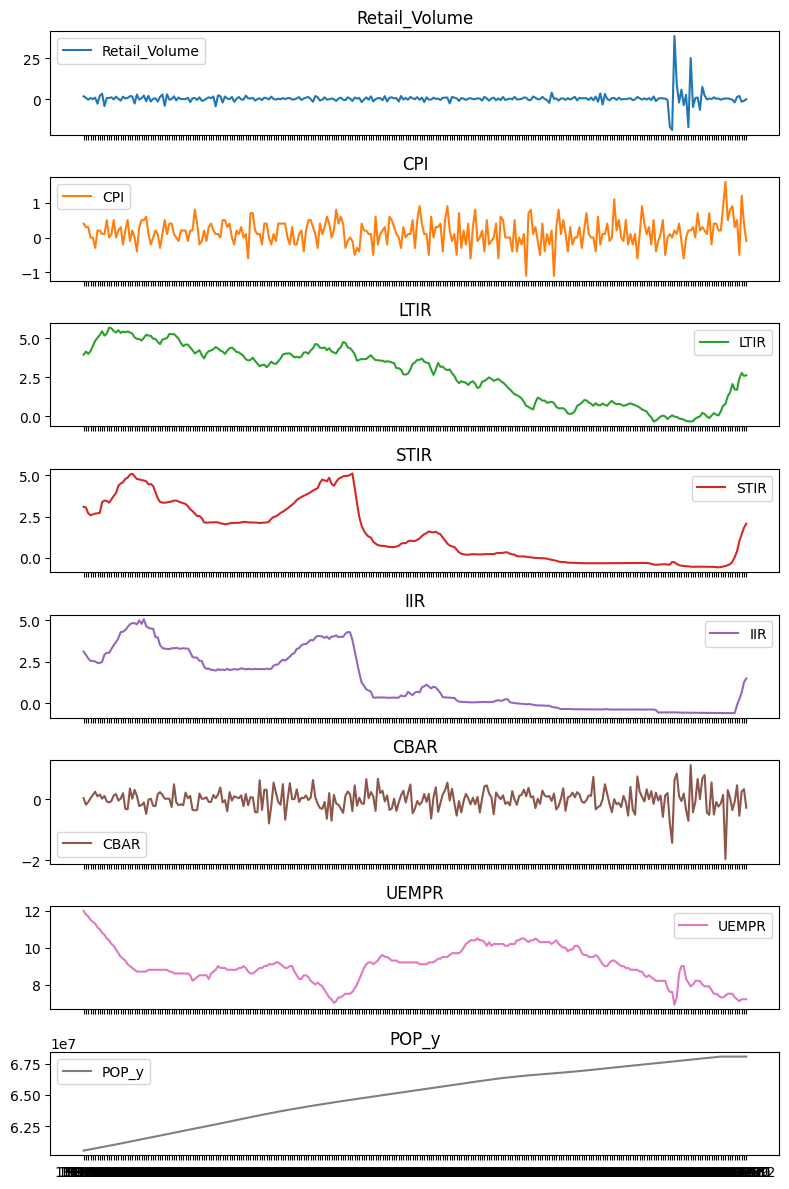

In [61]:
import matplotlib.pyplot as plt

# Select numeric columns
numeric_columns = df_filled.select_dtypes(include='number').columns

# Create subplots
fig, axes = plt.subplots(len(numeric_columns), 1, figsize=(8, 12), sharex=True)

# Plot each numeric column
colors = plt.cm.tab10.colors  # Use a colormap for different colors
for i, column in enumerate(numeric_columns):
    axes[i].plot(df_filled.index, df_filled[column], label=column, color=colors[i % len(colors)])  # Use index instead of 'DATE'
    axes[i].set_title(column)
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [62]:
df_test = df_filled[['Retail_Volume', 'CPI', 'LTIR', 'STIR', 'IIR', 'CBAR', 'UEMPR',"POP_y"]]

In [63]:
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
import pandas as pd

def check_stationarity_extended(df, signif=0.05, regression='c'):
    """
    Check stationarity for each numeric column using multiple tests:
    ADF, KPSS, and PP.

    Parameters:
    - df: pandas DataFrame with numeric columns.
    - signif: significance level (default=0.05)
    - regression: type of regression (default='c' → constant only).
                  Options: 'c' (constant), 'ct' (constant + trend), 'nc' (no constant)

    Returns:
    - pd.DataFrame: one row per column, including test statistics, p-values, and stationarity results.
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame.")

    results = []

    for col in df.select_dtypes(include='number').columns:
        row = {"Column": col}
        series = df[col].dropna()

        if len(series) < 10:
            row.update({
                "ADF_Stat": "Too short",
                "ADF_p-value": "Too short",
                "ADF_Stationary": "Too short",
                "KPSS_Stat": "Too short",
                "KPSS_p-value": "Too short",
                "KPSS_Stationary": "Too short",
                "PP_Stat": "Too short",
                "PP_p-value": "Too short",
                "PP_Stationary": "Too short"
            })
            results.append(row)
            continue

        # Augmented Dickey-Fuller
        try:
            adf_stat, adf_p, *_ = adfuller(series, regression=regression)
            row["ADF_Stat"] = adf_stat
            row["ADF_p-value"] = adf_p
            row["ADF_Stationary"] = adf_p < signif
        except Exception as e:
            row["ADF_Stat"] = f"Error: {str(e)}"
            row["ADF_p-value"] = f"Error: {str(e)}"
            row["ADF_Stationary"] = f"Error: {str(e)}"

        # KPSS (note: here null = stationary)
        try:
            kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
            row["KPSS_Stat"] = kpss_stat
            row["KPSS_p-value"] = kpss_p
            row["KPSS_Stationary"] = kpss_p > signif  # fail to reject ⇒ stationary
        except Exception as e:
            row["KPSS_Stat"] = f"Error: {str(e)}"
            row["KPSS_p-value"] = f"Error: {str(e)}"
            row["KPSS_Stationary"] = f"Error: {str(e)}"

        # Phillips-Perron
        try:
            pp_test = PhillipsPerron(series)
            row["PP_Stat"] = pp_test.stat
            row["PP_p-value"] = pp_test.pvalue
            row["PP_Stationary"] = pp_test.pvalue < signif
        except Exception as e:
            row["PP_Stat"] = f"Error: {str(e)}"
            row["PP_p-value"] = f"Error: {str(e)}"
            row["PP_Stationary"] = f"Error: {str(e)}"

        results.append(row)

    return pd.DataFrame(results)


In [64]:
check_stationarity_extended(df_test)

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_35711/2469383986.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_35711/2469383986.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_35711/2469383986.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_35711

,Column,ADF_Stat,ADF_p-value,ADF_Stationary,KPSS_Stat,KPSS_p-value,KPSS_Stationary,PP_Stat,PP_p-value,PP_Stationary
0,Retail_Volume,-8.095452,1.342899e-12,True,0.149854,0.10,True,-31.845998,0.000000e+00,True
1,CPI,-1.700570,4.308189e-01,False,0.177164,0.10,True,-17.170662,6.746779e-30,True
2,LTIR,-1.280830,6.378965e-01,False,2.418885,0.01,False,-1.182403,6.811193e-01,False
3,STIR,-2.148515,2.254589e-01,False,2.066286,0.01,False,-1.675160,4.439543e-01,False
4,IIR,-1.708638,4.266675e-01,False,2.148818,0.01,False,-1.647035,4.585870e-01,False
5,CBAR,-5.948606,2.174082e-07,True,0.024523,0.10,True,-20.035241,0.000000e+00,True
6,UEMPR,-2.130598,2.323905e-01,False,0.304612,0.10,True,-2.677583,7.799839e-02,False
7,POP_y,-2.477979,1.209245e-01,False,2.663491,0.01,False,-9.827687,5.135437e-17,True


- Retail_Volume: ✅ Stationary (Strong evidence)
- CPI: ⚠️ Mixed (likely trend-stationary)
- LTIR: ❌ Not stationary
- STIR: ❌ Not stationary
- IIR: ❌ Not stationary
- CBAR: ✅ Stationary (Strong evidence)
- UEMPR: ⚠️ Mixed (inconclusive)
- POP_y: ⚠️ Mixed

### ? Should I also check for joint stationarity

### Transformaiton to Make Data Stationary

#### Q-Q Test

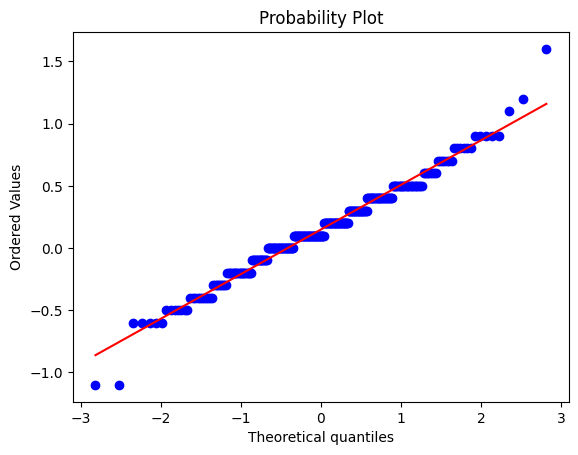

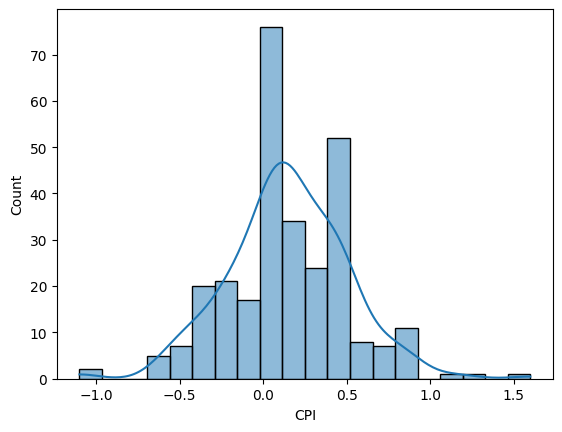

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

stats.probplot(df_test['CPI'], dist="norm", plot=plt)
plt.show()

sns.histplot(df_test['CPI'], kde=True)
plt.show()

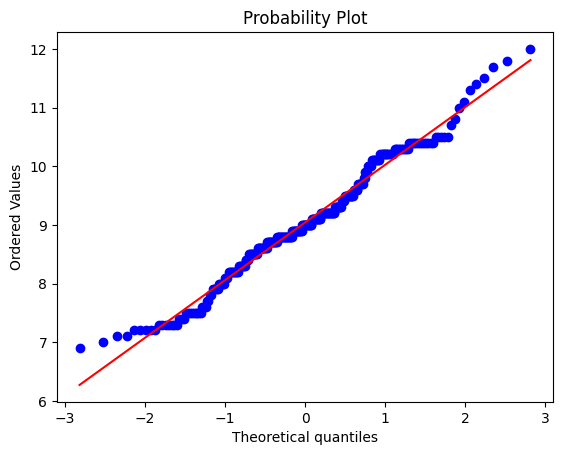

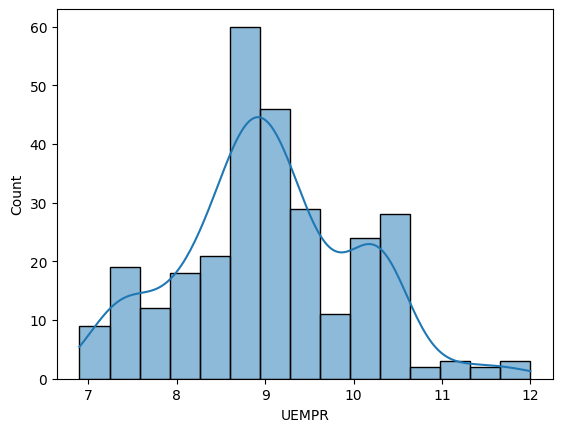

In [66]:
stats.probplot(df_test['UEMPR'], dist="norm", plot=plt)
plt.show()

sns.histplot(df_test['UEMPR'], kde=True)
plt.show()

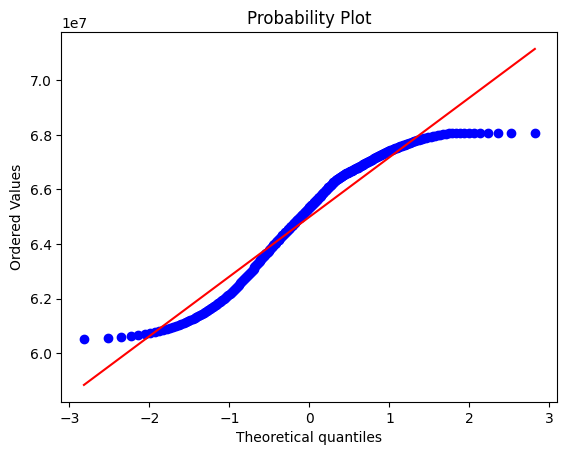

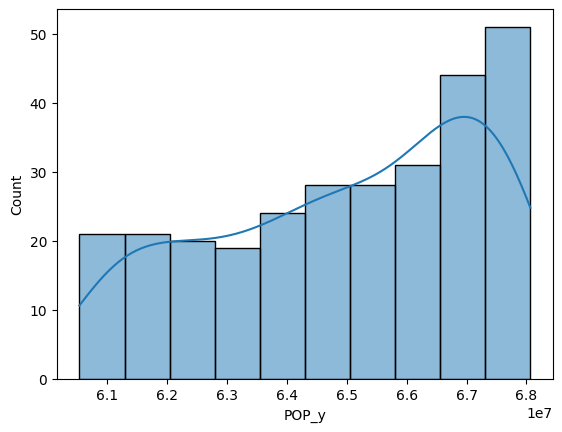

In [67]:
stats.probplot(df_test['POP_y'], dist="norm", plot=plt)
plt.show()

sns.histplot(df_test['POP_y'], kde=True)
plt.show()

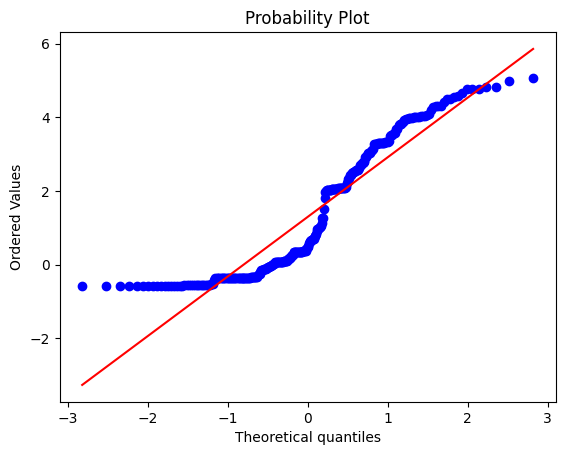

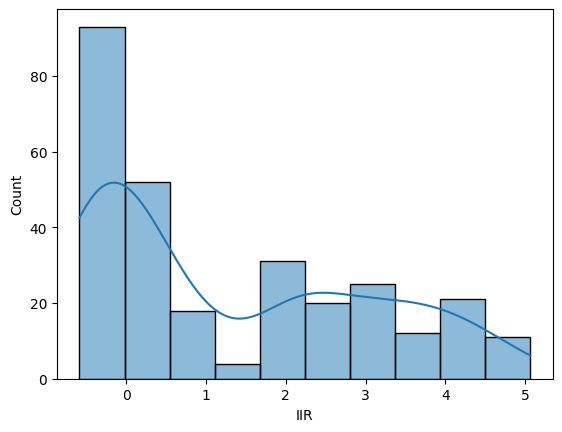

In [68]:

stats.probplot(df_test['IIR'], dist="norm", plot=plt)
plt.show()

sns.histplot(df_test['IIR'], kde=True)
plt.show()

Interest rates do not follow a normal distribution. Population and unemployment rates approximately follow a normal distribution. Consumer Price Index (CPI) is normally distributed.

#### ?? Mardia function 

In [69]:
import numpy as np
from typing import Tuple

## from https://github.com/quillan86/mvn-python/blob/master/mvn.py

def mardia_test(data: np.ndarray, cov: bool = True) -> Tuple[float, float, float, float]:
    """
    https://rdrr.io/cran/MVN/src/R/mvn.R
    https://stats.stackexchange.com/questions/317147/how-to-get-a-single-p-value-from-the-two-p-values-of-a-mardias-multinormality-t
    Mardia's multivariate skewness and kurtosis.
    Calculates the Mardia's multivariate skewness and kurtosis coefficients
    as well as their corresponding statistical test. For large sample size
    the multivariate skewness is asymptotically distributed as a Chi-square
    random variable; here it is corrected for small sample size. However,
    both uncorrected and corrected skewness statistic are presented. Likewise,
    the multivariate kurtosis it is distributed as a unit-normal.

     Syntax: function [Mskekur] = Mskekur(X,c,alpha)

     Inputs:
          X - multivariate data matrix [Size of matrix must be n(data)-by-p(variables)].
          cov - boolean to whether to normalize the covariance matrix by n (c=1[default]) or by n-1 (c~=1)

     Outputs:
          - skewness test statistic
          - kurtosis test statistic
          - significance value for skewness
          - significance value for kurtosis
    """
    n, p = data.shape

    # correct for small sample size
    small: bool = True if n < 20 else False

    if cov:
        S = ((n - 1)/n) * np.cov(data.T)
    else:
        S = np.cov(data.T)

    # calculate mean
    data_mean = data.mean(axis=0)
    # inverse - check if singular matrix
    try:
        iS = np.linalg.inv(S)
    except Exception as e:
        # print for now
        print(e)
        return 0.0, 0.0, 0.0, 0.0
    # squared-Mahalanobis' distances matrix
    D: np.ndarray = (data - data_mean) @ iS @ (data - data_mean).T
    # multivariate skewness coefficient
    g1p: float = np.sum(D**3)/n**2
    # multivariate kurtosis coefficient
    g2p: float = np.trace(D**2)/n
    # small sample correction
    k: float = ((p + 1)*(n + 1)*(n + 3))/(n*(((n + 1)*(p + 1)) - 6))
    # degrees of freedom
    df: float = (p * (p + 1) * (p + 2))/6

    if small:
        # skewness test statistic corrected for small sample: it approximates to a chi-square distribution
        g_skew = (n * g1p * k)/6
    else:
        # skewness test statistic:it approximates to a chi-square distribution
        g_skew = (n * g1p)/6

    # significance value associated to the skewness corrected for small sample
    p_skew: float = 1.0 - stats.chi2.cdf(g_skew, df)

    # kurtosis test statistic: it approximates to a unit-normal distribution
    g_kurt = (g2p - (p*(p + 2)))/(np.sqrt((8 * p * (p + 2))/n))
    # significance value associated to the kurtosis
    p_kurt: float = 2 * (1.0 - stats.norm.cdf(np.abs(g_kurt)))

    return g_skew, g_kurt, p_skew, p_kurt

mardia_test(df_test[[ 'CPI', 'UEMPR']].to_numpy(), cov=True)

(np.float64(3.7606169505051685),
 np.float64(2.4854068558475073),
 np.float64(0.43937101885846064),
 np.float64(0.012940344612128563))

#### ?? Transforming the Data

In [70]:
import numpy as np
import pandas as pd
from scipy.stats import boxcox, chi2
from scipy.optimize import minimize
from statsmodels.tools.eval_measures import aic

def boxcox_log_likelihood(X, lambdas):
    """
    Computes the log-likelihood of the Box-Cox transformation for multivariate data.
    """
    n_obs, n_vars = X.shape
    transformed = np.zeros_like(X)
    log_likelihood = 0

    for j in range(n_vars):
        col = X[:, j]
        lam = lambdas[j]
        if np.any(col <= 0):
            raise ValueError("Box-Cox requires strictly positive data.")
        
        if np.isclose(lam, 0):
            transformed[:, j] = np.log(col)
        else:
            transformed[:, j] = (col**lam - 1) / lam
        log_likelihood += (lam - 1) * np.sum(np.log(col))
    
    cov = np.cov(transformed.T)
    sign, logdet = np.linalg.slogdet(cov)
    if sign != 1:
        return -np.inf
    log_likelihood -= 0.5 * n_obs * logdet
    return log_likelihood

def find_optimal_lambda(X):
    """
    Finds the optimal lambda vector that maximizes the multivariate Box-Cox log-likelihood.
    """
    n_vars = X.shape[1]
    bounds = [(-5, 5)] * n_vars
    init = np.ones(n_vars)

    result = minimize(
        lambda lam: -boxcox_log_likelihood(X, lam),
        x0=init,
        bounds=bounds,
        method='L-BFGS-B'
    )

    return result.x, -result.fun

def transform_data_with_lambda(X, lambdas):
    """
    Applies Box-Cox transformation with specific lambdas.
    """
    transformed = np.zeros_like(X)
    for j in range(X.shape[1]):
        col = X[:, j]
        lam = lambdas[j]
        if np.isclose(lam, 0):
            transformed[:, j] = np.log(col)
        else:
            transformed[:, j] = (col**lam - 1) / lam
    return transformed

def boxcox_joint_test(X, lambda_null=None, alpha=0.05):
    """
    Main function: test Box-Cox transformation for multivariate stationarity.
    """
    X = np.asarray(X)
    opt_lambda, lmax_star = find_optimal_lambda(X)

    if lambda_null is None:
        lambda_null = np.ones(X.shape[1])  # default: no transformation
    lmax_null = boxcox_log_likelihood(X, lambda_null)

    # Likelihood Ratio Test
    LK = 2 * (lmax_star - lmax_null)
    tau = chi2.ppf(1 - alpha, df=X.shape[1])
    reject = LK > tau

    transformed_data = transform_data_with_lambda(X, opt_lambda)

    return {
        "optimal_lambda": opt_lambda,
        "LK_stat": LK,
        "critical_value": tau,
        "reject_H0": reject,
        "transformed_data": transformed_data
    }


In [71]:
# df: a pandas DataFrame with only positive values
result = boxcox_joint_test(df_test[['UEMPR','POP_y']].values)

print("Optimal Lambda:", result["optimal_lambda"])
print("Reject Null Hypothesis:", result["reject_H0"])


Optimal Lambda: [0.33786605 5.        ]
Reject Null Hypothesis: True


In [72]:
['CPI', 'LTIR', 'STIR', 'IIR', 'UEMPR','POP_y']

['CPI', 'LTIR', 'STIR', 'IIR', 'UEMPR', 'POP_y']

#### Differencing

In [73]:
diff_df = df_test[['CPI', 'LTIR', 'STIR', 'IIR', 'UEMPR','POP_y']].diff().dropna()   

In [74]:
check_stationarity_extended(diff_df)

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_35711/2469383986.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_35711/2469383986.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_35711/2469383986.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_35711

,Column,ADF_Stat,ADF_p-value,ADF_Stationary,KPSS_Stat,KPSS_p-value,KPSS_Stationary,PP_Stat,PP_p-value,PP_Stationary
0,CPI,-9.825575,5.198753e-17,True,0.162856,0.10,True,-68.825957,0.000000e+00,True
1,LTIR,-8.206481,7.002397e-13,True,0.187415,0.10,True,-12.605981,1.695536e-23,True
2,STIR,-4.448732,2.431218e-04,True,0.129903,0.10,True,-7.264028,1.652919e-10,True
3,IIR,-4.370667,3.343957e-04,True,0.123956,0.10,True,-10.287465,3.643092e-18,True
4,UEMPR,-4.910951,3.320242e-05,True,0.290358,0.10,True,-11.473355,5.201964e-21,True
5,POP_y,0.232388,9.740208e-01,False,2.387067,0.01,False,0.427396,9.824910e-01,False


In [75]:
diff_df

,CPI,LTIR,STIR,IIR,UEMPR,POP_y
DATE,,,,,,
1999-03,-0.1,0.1990,-0.046704,-0.192800,-0.2,34722.916667
1999-04,0.0,-0.1474,-0.350241,-0.216100,-0.1,34722.916667
1999-05,-0.3,0.1793,-0.117503,-0.158100,-0.2,34722.916667
1999-06,0.0,0.3207,0.047730,0.012200,-0.1,34722.916667
1999-07,-0.3,0.3327,0.049773,-0.042300,-0.1,34722.916667
...,...,...,...,...,...,...
2022-08,0.2,-0.0200,0.358120,0.476412,-0.1,0.000000
2022-09,-1.0,0.7200,0.616125,0.349236,-0.1,0.000000
2022-10,1.7,0.3600,0.416803,0.400795,0.1,0.000000


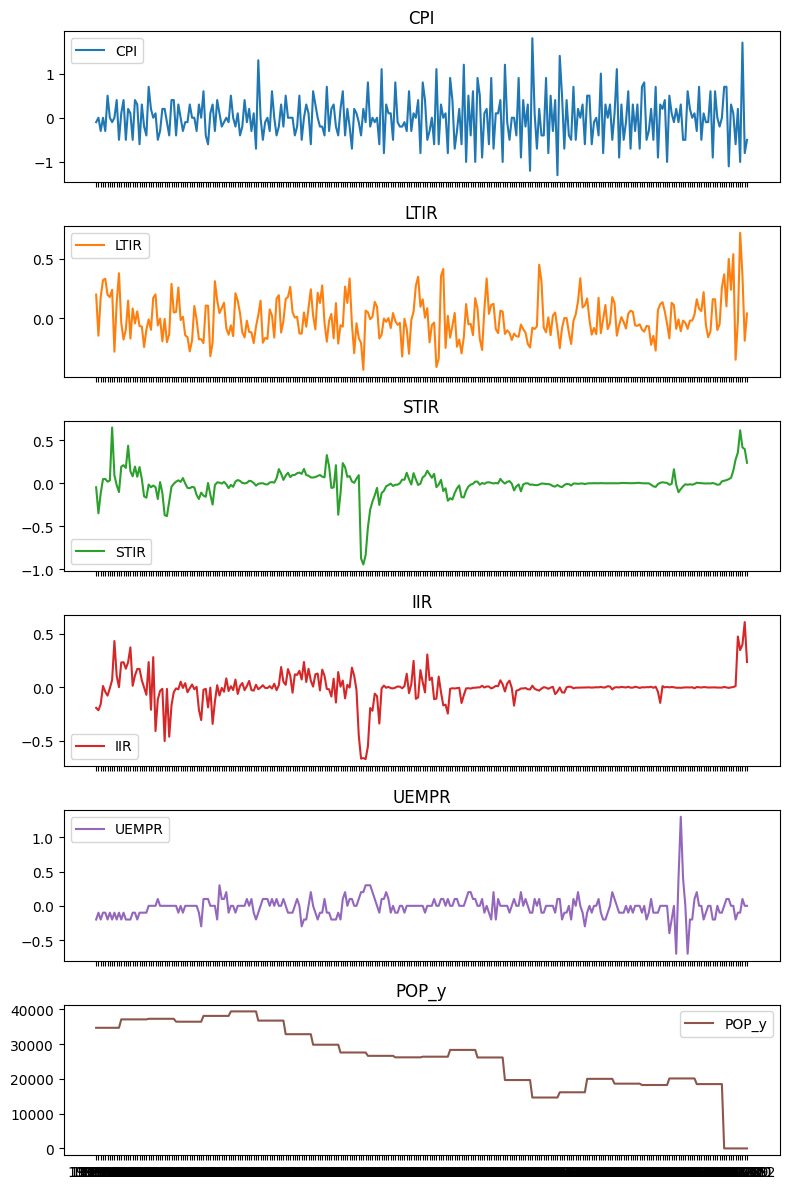

In [76]:
import matplotlib.pyplot as plt

# Select numeric columns

# Create subplots
fig, axes = plt.subplots(len(diff_df.columns), 1, figsize=(8, 12), sharex=True)

# Plot each numeric column
colors = plt.cm.tab10.colors  # Use a colormap for different colors
for i, column in enumerate(diff_df.columns):
    axes[i].plot(diff_df.index, diff_df[column], label=column, color=colors[i % len(colors)])
    axes[i].set_title(column)
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

# **CCF and PCCF**

In [77]:
df_stationary = df_test[["Retail_Volume", "CBAR"]].merge(diff_df, left_index=True, right_index=True).dropna()

In [78]:
df_stationary

,Retail_Volume,CBAR,CPI,LTIR,STIR,IIR,UEMPR,POP_y
DATE,,,,,,,,
1999-03,0.8,-0.182699,-0.1,0.1990,-0.046704,-0.192800,-0.2,34722.916667
1999-04,-0.4,-0.091516,0.0,-0.1474,-0.350241,-0.216100,-0.1,34722.916667
1999-05,0.7,0.030533,-0.3,0.1793,-0.117503,-0.158100,-0.2,34722.916667
1999-06,0.0,0.137358,0.0,0.3207,0.047730,0.012200,-0.1,34722.916667
1999-07,0.9,0.243858,-0.3,0.3327,0.049773,-0.042300,-0.1,34722.916667
...,...,...,...,...,...,...,...,...
2022-08,1.3,0.454176,0.2,-0.0200,0.358120,0.476412,-0.1,0.000000
2022-09,1.9,-0.545665,-1.0,0.7200,0.616125,0.349236,-0.1,0.000000
2022-10,-1.6,0.250815,1.7,0.3600,0.416803,0.400795,0.1,0.000000


## CCF

In [79]:
from statsmodels.tsa.stattools import ccf 

def top_ccf_values(series1, series2, top_n=3):
    ccf_values = ccf(series1, series2)
    abs_values_with_index = [(i, val) for i, val in enumerate(ccf_values)]
    top_values = sorted(abs_values_with_index, key=lambda x: abs(x[1]), reverse=True)[:top_n]
    
    print("Top CCF Values:")
    for idx, value in top_values:
        print(f"Index: {idx}, Value: {value}")

    return top_values


In [80]:
df_stationary.shape

(286, 8)

In [128]:
df_stationary

,Retail_Volume,CBAR,CPI,LTIR,STIR,IIR,UEMPR,POP_y
DATE,,,,,,,,
1999-03,0.8,-0.182699,-0.1,0.1990,-0.046704,-0.192800,-0.2,34722.916667
1999-04,-0.4,-0.091516,0.0,-0.1474,-0.350241,-0.216100,-0.1,34722.916667
1999-05,0.7,0.030533,-0.3,0.1793,-0.117503,-0.158100,-0.2,34722.916667
1999-06,0.0,0.137358,0.0,0.3207,0.047730,0.012200,-0.1,34722.916667
1999-07,0.9,0.243858,-0.3,0.3327,0.049773,-0.042300,-0.1,34722.916667
...,...,...,...,...,...,...,...,...
2022-08,1.3,0.454176,0.2,-0.0200,0.358120,0.476412,-0.1,0.000000
2022-09,1.9,-0.545665,-1.0,0.7200,0.616125,0.349236,-0.1,0.000000
2022-10,-1.6,0.250815,1.7,0.3600,0.416803,0.400795,0.1,0.000000


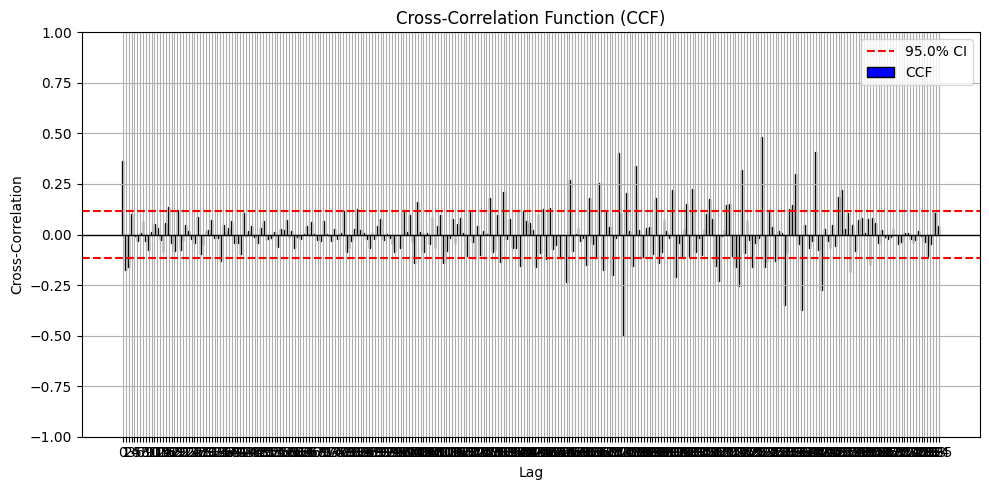

Top CCF Values:
Index: 175, Value: -0.5012036305787634
Index: 223, Value: 0.4837707273604419
Index: 242, Value: 0.4060176242869731


[(175, np.float64(-0.5012036305787634)),
 (223, np.float64(0.4837707273604419)),
 (242, np.float64(0.4060176242869731))]

In [81]:

utils.ccf_plot(df_stationary["Retail_Volume"],df_stationary['CBAR'],286)

# Example usage:
top_ccf_values(df_stationary["Retail_Volume"], df_stationary['CBAR'])

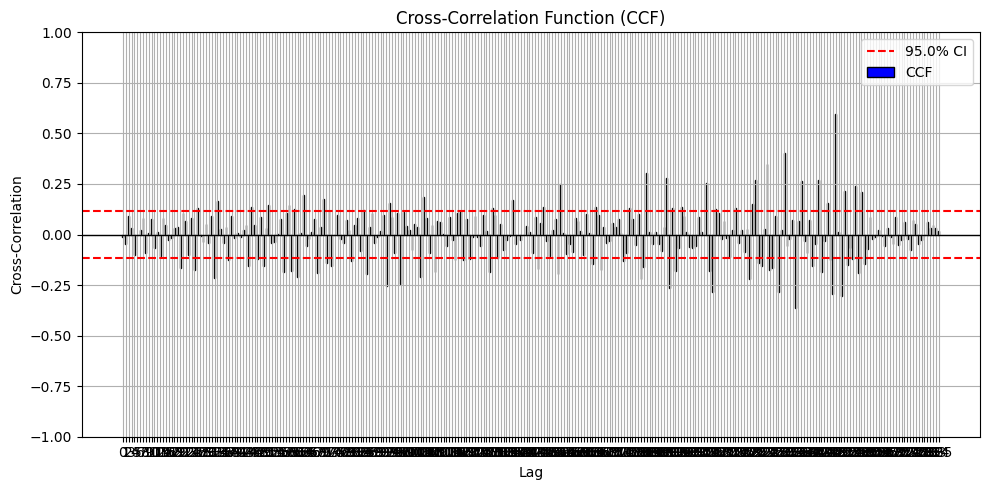

Top CCF Values:
Index: 249, Value: 0.5951852229936231
Index: 231, Value: 0.4010548307456143
Index: 235, Value: -0.3627408211471829


[(249, np.float64(0.5951852229936231)),
 (231, np.float64(0.4010548307456143)),
 (235, np.float64(-0.3627408211471829))]

In [82]:
utils.ccf_plot(df_stationary["Retail_Volume"],df_stationary["CPI"],nlags=286)
top_ccf_values(df_stationary["Retail_Volume"], df_stationary['CPI'])

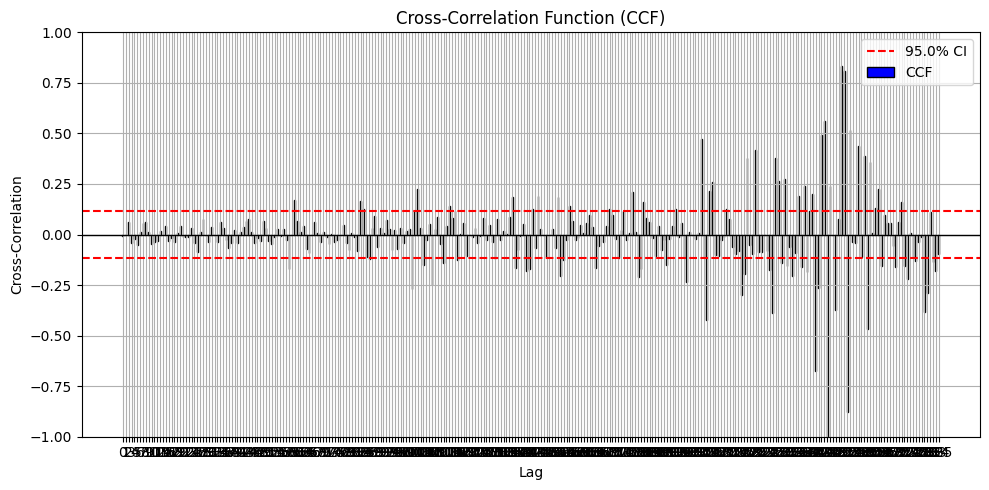

Top CCF Values:
Index: 246, Value: -1.0388586841680245
Index: 253, Value: -0.8760765604327244
Index: 251, Value: 0.8355193997345758


[(246, np.float64(-1.0388586841680245)),
 (253, np.float64(-0.8760765604327244)),
 (251, np.float64(0.8355193997345758))]

In [83]:
utils.ccf_plot(df_stationary["Retail_Volume"],df_stationary["LTIR"],nlags=286)
top_ccf_values(df_stationary["Retail_Volume"], df_stationary['LTIR'])

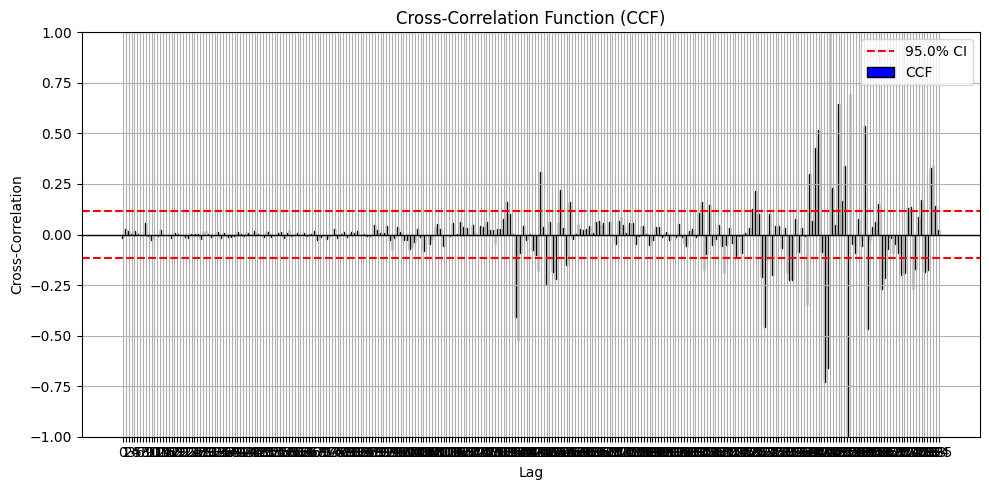

Top CCF Values:
Index: 247, Value: 1.518793803112136
Index: 253, Value: -1.102351031242704
Index: 245, Value: -0.7273094794160457


[(247, np.float64(1.518793803112136)),
 (253, np.float64(-1.102351031242704)),
 (245, np.float64(-0.7273094794160457))]

In [84]:
utils.ccf_plot(df_stationary["Retail_Volume"],df_stationary["STIR"],nlags=286)
top_ccf_values(df_stationary["Retail_Volume"], df_stationary['STIR'])

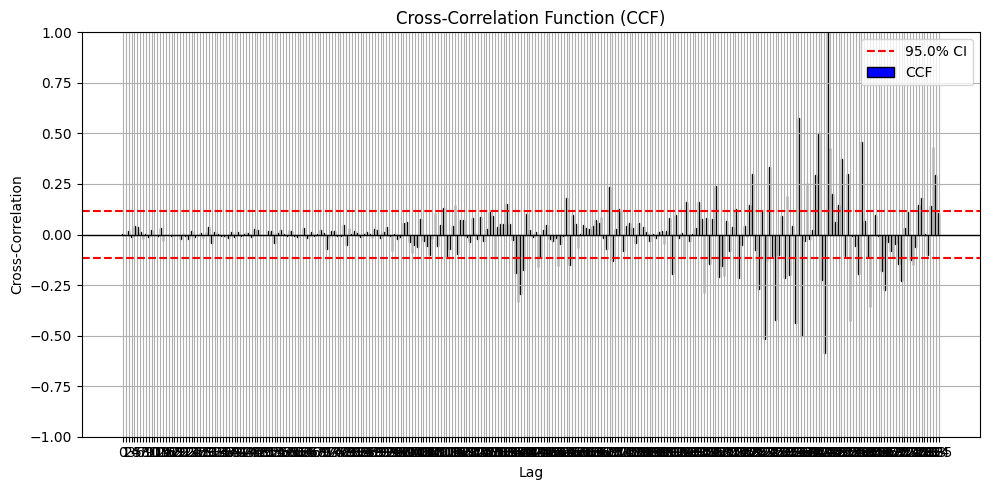

Top CCF Values:
Index: 246, Value: 1.0940870584777695
Index: 245, Value: -0.5835180026657283
Index: 236, Value: 0.5783144100787154


[(246, np.float64(1.0940870584777695)),
 (245, np.float64(-0.5835180026657283)),
 (236, np.float64(0.5783144100787154))]

In [85]:
utils.ccf_plot(df_stationary["Retail_Volume"],df_stationary["IIR"],nlags=286)
top_ccf_values(df_stationary["Retail_Volume"], df_stationary['IIR'])

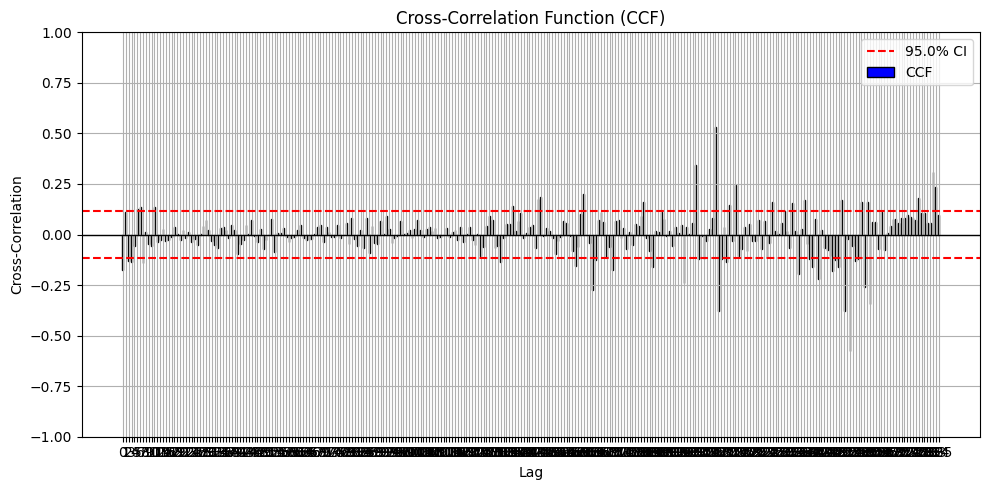

Top CCF Values:
Index: 254, Value: -0.5782132477270733
Index: 207, Value: 0.5312077818493254
Index: 252, Value: -0.38065376826922814


[(254, np.float64(-0.5782132477270733)),
 (207, np.float64(0.5312077818493254)),
 (252, np.float64(-0.38065376826922814))]

In [86]:
utils.ccf_plot(df_stationary["Retail_Volume"],df_stationary["UEMPR"],nlags=286)
top_ccf_values(df_stationary["Retail_Volume"], df_stationary['UEMPR'])

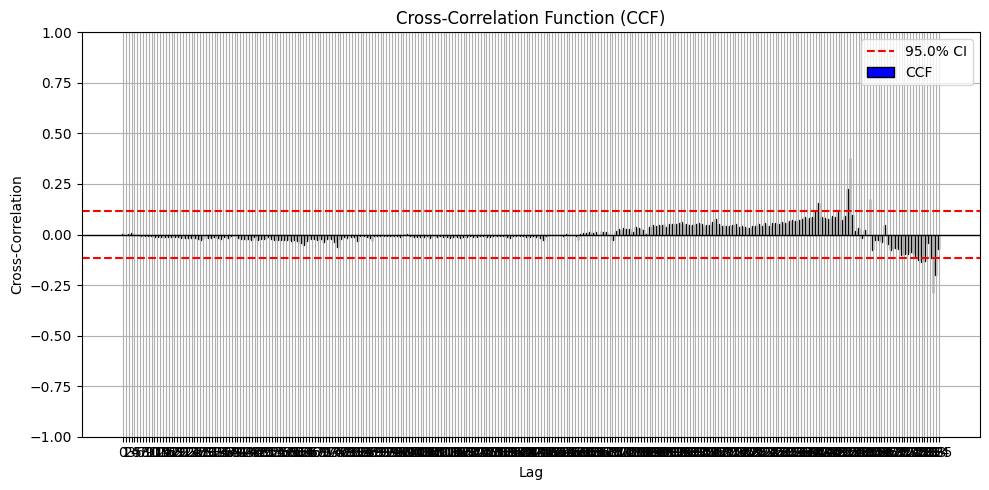

Top CCF Values:
Index: 254, Value: 0.3805710958021897
Index: 283, Value: -0.2915397104271012
Index: 253, Value: 0.22451257343639666


[(254, np.float64(0.3805710958021897)),
 (283, np.float64(-0.2915397104271012)),
 (253, np.float64(0.22451257343639666))]

In [87]:
utils.ccf_plot(df_stationary["Retail_Volume"],df_stationary["POP_y"],nlags=286)
top_ccf_values(df_stationary["Retail_Volume"], df_stationary['POP_y'])


## PCCF

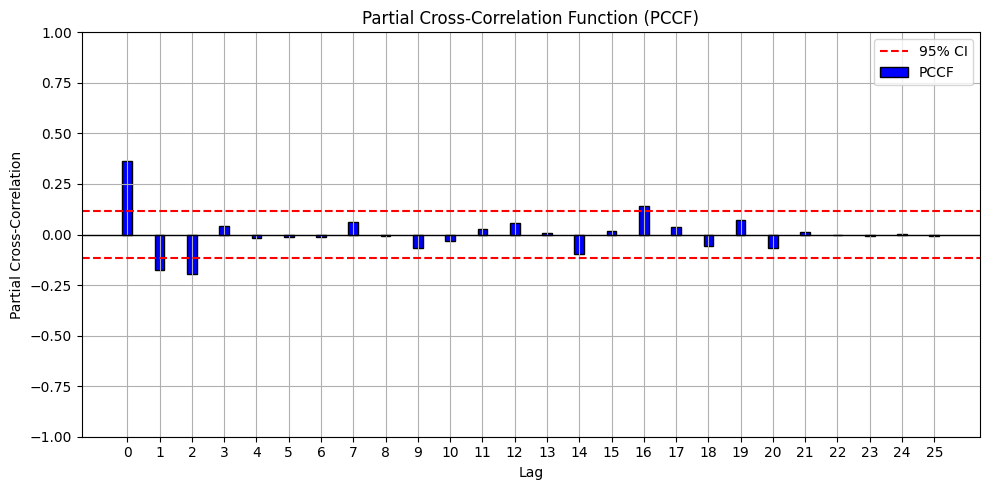

In [88]:
utils.pccf_plot(df_stationary["Retail_Volume"],df_stationary['CBAR'],nlags=25)

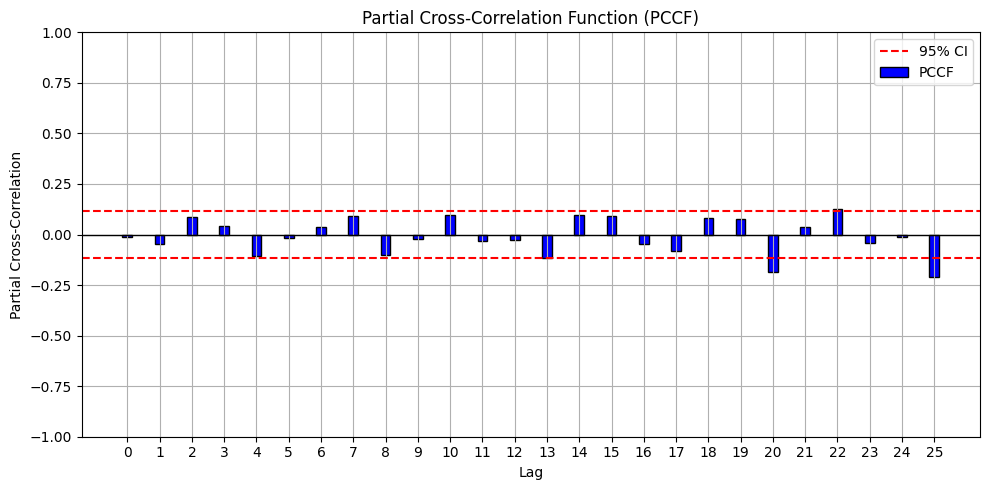

In [89]:
utils.pccf_plot(df_stationary["Retail_Volume"],df_stationary["CPI"],nlags=25)

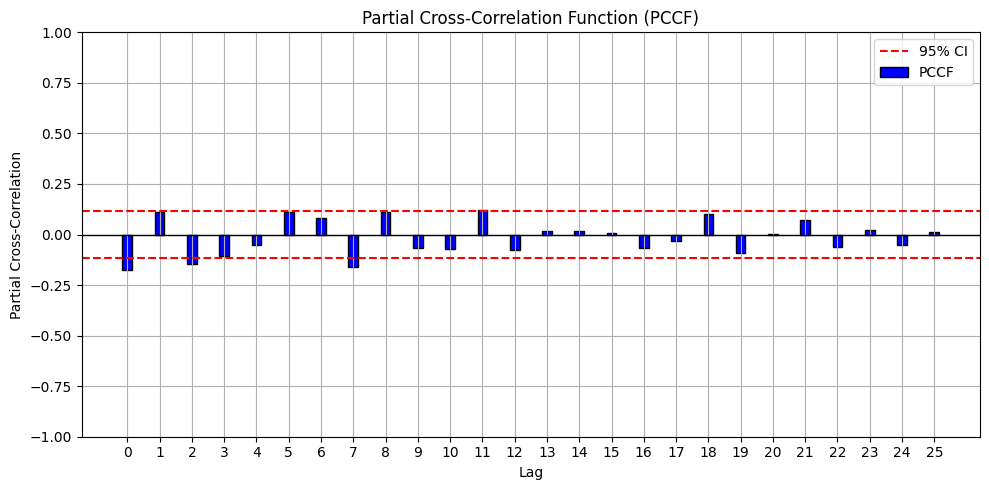

In [90]:
utils.pccf_plot(df_stationary["Retail_Volume"],df_stationary["UEMPR"],nlags=25)

# **Feature importance analysis**

In [94]:
reg_data = df_stationary.copy()

### ANOVA

In [95]:
print(reg_data.isnull().sum())

Retail_Volume    0
CBAR             0
CPI              0
LTIR             0
STIR             0
IIR              0
UEMPR            0
POP_y            0
dtype: int64


Only CBAR has a correlation

In [96]:
correlation_matrix = reg_data.corr()
print(correlation_matrix['Retail_Volume'])

Retail_Volume    1.000000
CBAR             0.363889
CPI             -0.010995
LTIR            -0.009150
STIR            -0.017954
IIR              0.001478
UEMPR           -0.175941
POP_y            0.000397
Name: Retail_Volume, dtype: float64


error interval?
farklı zaman pencerelerinde hesapla ve t teste at

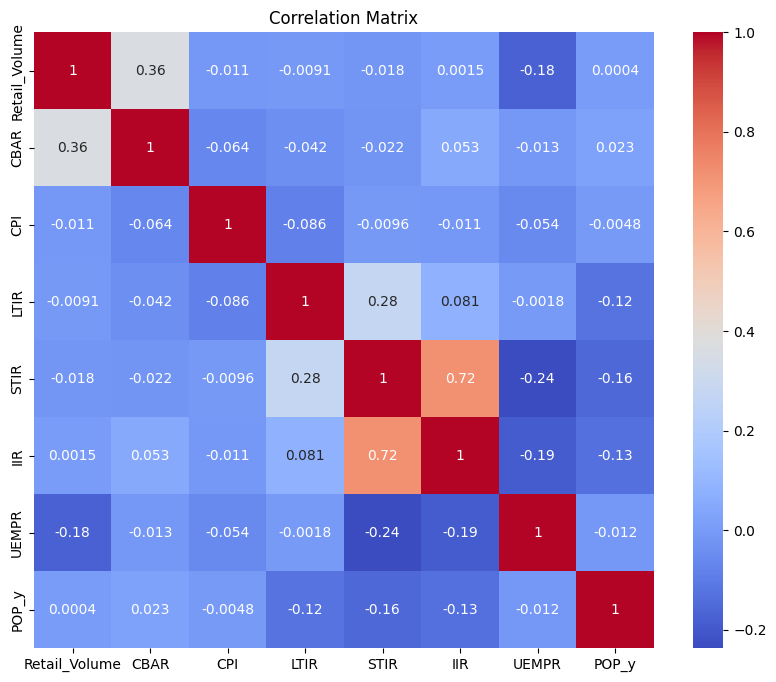

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'housing_df' is the DataFrame containing the data
# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(reg_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### multicolinearity

When Ri2 is equal to 0, and therefore, when VIF or tolerance is equal to 1, the ith independent variable is not correlated to the remaining ones, meaning that multicollinearity does not exist.

1. In general terms,
    - VIF equal to 1 = variables are not correlated
    - VIF between 1 and 5 = variables are moderately correlated 
    - VIF greater than 5 = variables are highly correlated

2. The higher the VIF, the higher the possibility that multicollinearity exists, and further research is required. When VIF is higher than 10, there is significant multicollinearity that needs to be corrected.

This output shows the VIF value for each predictor variable, indicating multicollinearity levels in the dataset. The const row represents the intercept term, with a VIF close to 1, meaning it has no multicollinearity. Among the predictor variables, Product_range has the highest VIF (5.94), which suggests that it needs corrective measures. All the other predictors have VIF values below 3, indicating low multicollinearity. 



In [98]:
reg_data.columns

Index(['Retail_Volume', 'CBAR', 'CPI', 'LTIR', 'STIR', 'IIR', 'UEMPR',
       'POP_y'],
      dtype='object')

In [99]:
from sklearn.preprocessing import StandardScaler

selected_features = [ 'CPI', 'LTIR', 'STIR', 'IIR', 'CBAR', 'UEMPR', 'POP_y']
X = reg_data[selected_features]
y = reg_data['Retail_Volume']


# Initialize the StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the data and transform it
X_scaled = scaler.fit_transform(X)

# Print the scaled data
print(X_scaled)

[[-0.19252045  1.18363577 -0.28416156 ... -0.52159753 -1.19531319
   0.90136568]
 [ 0.00342563 -0.83010021 -2.28527084 ... -0.24840038 -0.54290943
   0.90136568]
 [-0.58441261  1.06911326 -0.75091367 ...  0.11728202 -1.19531319
   0.90136568]
 ...
 [ 3.33450898  2.11958119  2.77157187 ...  0.77728404  0.7618981
  -2.82451753]
 [-1.564143   -1.07774788  2.64470976 ...  1.00965564  0.10949434
  -2.82451753]
 [-0.97630476  0.25931701  1.59443015 ... -0.81474735  0.10949434
  -2.82451753]]


You will use Standardization to ensure all features are on the same scale, improving model performance and comparability.



In [100]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Select features
features = ['CPI', 'LTIR', 'STIR', 'IIR', 'CBAR', 'UEMPR', 'POP_y']
X_raw = reg_data[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Add intercept after scaling
X = add_constant(X_scaled)

# Calculate VIF
vif = pd.DataFrame()
vif['Variable'] = ['const'] + features
vif['VIF'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif


,Variable,VIF
0,const,1.000000
1,CPI,1.015850
2,LTIR,1.140233
3,STIR,2.383829
4,IIR,2.164856
5,CBAR,1.015808
6,UEMPR,1.070533
7,POP_y,1.038256


#### Model

**Mean Squared Error (MSE):** The MSE measures the average squared difference between the predicted and actual values of the target variable. A lower MSE indicates better model performance, as it means the model is making more accurate predictions

**R-squared (R2):**  R-squared measures the proportion of the variance in the dependent variable that is predictable from the independent variables. It ranges from 0 to 1, where 1 is perfect prediction and 0 indicates no linear relationship



In [101]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# The 'LinearRegression' model is initialized and fitted to the training data.
model = LinearRegression()
model.fit(X_train, y_train)

# The model is used to predict the target variable for the test set.
y_pred = model.predict(X_test)


print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))


Mean Squared Error: 4.689066431242956
R-squared: -0.9182897003878536


In [126]:
# select the best alpha with RidgeCV
from sklearn.linear_model import RidgeCV
alpha_range = 10.**np.arange(-2, 3)
ridgeregcv = RidgeCV(alphas=alpha_range, scoring='neg_mean_squared_error')
ridgeregcv.fit(X_train, y_train)

# The model is used to predict the target variable for the test set.
y_pred = ridgeregcv.predict(X_test)


print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

Mean Squared Error: 3.430679529276086
R-squared: -0.40348559843228626


In [123]:
# The 'LinearRegression' model is initialized and fitted to the training data.
from sklearn.linear_model import LassoCV
lassoregcv = LassoCV(n_alphas=100, random_state=1)
lassoregcv.fit(X_train, y_train)

# The model is used to predict the target variable for the test set.
y_pred = lassoregcv.predict(X_test)


print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

Mean Squared Error: 2.593765641417518
R-squared: -0.061105443505566015


#### Homoscedasticity

**Homoscedasticity**: The variance of residuals is constant across all levels of the independent variables. A residual plot can help verify this.

noktalar restgele dağılmalı

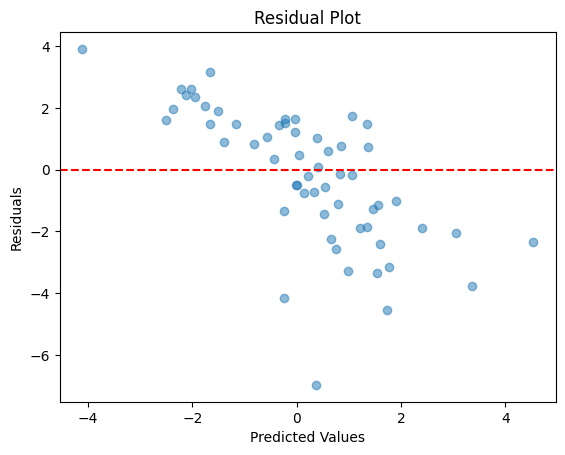

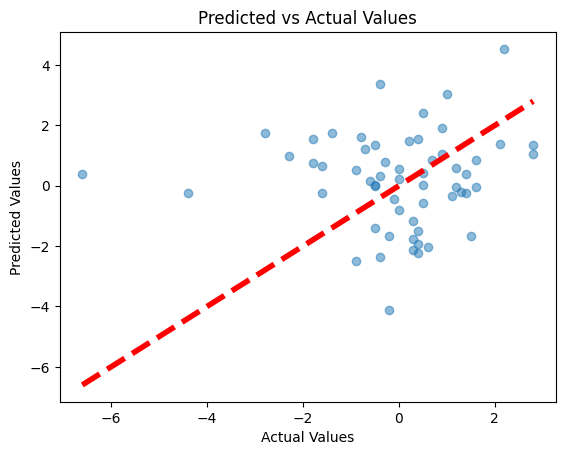

In [102]:
# Residual Plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Predicted vs Actual Plot 
### kontrol ett
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=4)
plt.show()

Truth: mean=-0.021, std=1.563
Pred:  mean=0.193, std=1.557


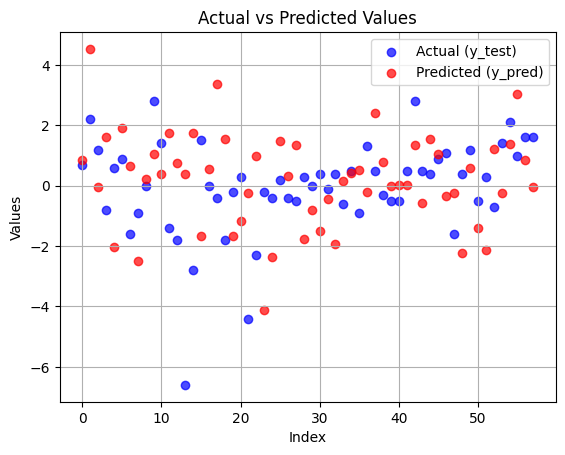

Pearson's correlation: 0.046


In [103]:
import numpy as np
from numpy import mean, std, min as np_min, max as np_max
from matplotlib import pyplot as plt
from scipy.stats import pearsonr

# Descriptive stats
print(f'Truth: mean={mean(y_test):.3f}, std={std(y_test):.3f}')
print(f'Pred:  mean={mean(y_pred):.3f}, std={std(y_pred):.3f}')


# Plot predicted vs actual as separate points along index
plt.scatter(np.arange(len(y_test)), y_test, color='blue', label='Actual (y_test)', alpha=0.7)
plt.scatter(np.arange(len(y_pred)), y_pred, color='red', label='Predicted (y_pred)', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')



plt.legend()
plt.grid(True)
plt.show()

# Pearson correlation
corr, _ = pearsonr(y_test, y_pred)
print(f"Pearson's correlation: {corr:.3f}")

#### ANOVA Tests

                            OLS Regression Results                            
Dep. Variable:          Retail_Volume   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     3.019
Date:                Wed, 16 Apr 2025   Prob (F-statistic):           3.54e-11
Time:                        12:13:26   Log-Likelihood:                -593.50
No. Observations:                 286   AIC:                             1443.
Df Residuals:                     158   BIC:                             1911.
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

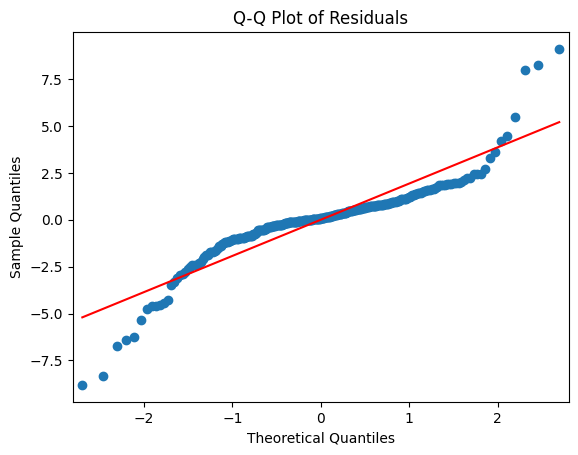

In [105]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Add a constant to the model
model_sm = ols('Retail_Volume ~ CPI* LTIR * STIR * IIR * CBAR * UEMPR * POP_y', data=reg_data).fit()
print(model_sm.summary())

# Q-Q Plot for residuals
sm.qqplot(model_sm.resid, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

In [106]:
import statsmodels.api as sm

# Assume `results` is your RegressionResultsWrapper object
conf_int = model_sm.conf_int(alpha=0.05)  # 95% confidence interval
conf_int.columns = ['0.025', '0.975']    # Rename columns for clarity
conf_int['coefficient'] = model_sm.params  # Add coefficients

# Combine with variable names (index)
summary_df = conf_int[['coefficient', '0.025', '0.975']]
non_zero_coef = summary_df[~((summary_df["0.025"] < 0) & (summary_df["0.975"] > 0))]


In [110]:
non_zero_coef.reindex(non_zero_coef['coefficient'].abs().sort_values(ascending=False).index)

,coefficient,0.025,0.975
CPI:LTIR:STIR:CBAR:UEMPR,48800.282985,16819.934708,80780.631262
LTIR:STIR:CBAR:UEMPR,21601.251690,6033.029172,37169.474208
CPI:LTIR:STIR:UEMPR,12132.632259,3821.041423,20444.223094
CPI:STIR:CBAR:UEMPR,6811.196826,1771.035813,11851.357839
CPI:LTIR:STIR:CBAR,-5094.362730,-8681.755450,-1506.970011
LTIR:STIR:UEMPR,4113.903581,909.770141,7318.037021
STIR:CBAR:UEMPR,-1955.626553,-3056.616640,-854.636466
CPI:STIR:UEMPR,1627.912346,250.287417,3005.537275
CBAR:UEMPR,-169.123016,-229.276212,-108.969821
CPI:LTIR:STIR:CBAR:UEMPR:POP_y,-1.545390,-2.666874,-0.423907


In [112]:
anova_table = sm.stats.anova_lm(model_sm, typ=2)
anova_table.sort_values(by="sum_sq", ascending=False).head(30)

,sum_sq,df,F,PR(>F)
Residual,1062.554250,158.0,NaN,NaN
CBAR:UEMPR,536.179965,1.0,79.729044,1.040749e-15
CBAR,506.258345,1.0,75.279750,4.716543e-15
STIR:CBAR:UEMPR,175.900281,1.0,26.156071,9.012603e-07
UEMPR,161.585467,1.0,24.027483,2.335634e-06
STIR:CBAR:UEMPR:POP_y,150.310487,1.0,22.350912,4.994044e-06
CBAR:UEMPR:POP_y,89.395205,1.0,13.292914,3.611498e-04
STIR:UEMPR,55.567038,1.0,8.262724,4.604489e-03
CBAR:POP_y,52.395245,1.0,7.791083,5.898181e-03
CPI:LTIR:STIR:CBAR:UEMPR:POP_y,47.269372,1.0,7.028875,8.837536e-03


In [ ]:
test_a = non_zero_coef.index.tolist()

# Step 1: Sort ANOVA table and get top 30 features
test_b = anova_table.sort_values("sum_sq", ascending=False).head(7).index.tolist()
# Step 2: Remove 'Residual' if it's present (not a feature)
test_b = [feat for feat in test_b if feat.lower() != 'residual']


                            OLS Regression Results                            
Dep. Variable:          Retail_Volume   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     7.047
Date:                Wed, 16 Apr 2025   Prob (F-statistic):           1.25e-14
Time:                        12:22:21   Log-Likelihood:                -714.04
No. Observations:                 286   AIC:                             1466.
Df Residuals:                     267   BIC:                             1536.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

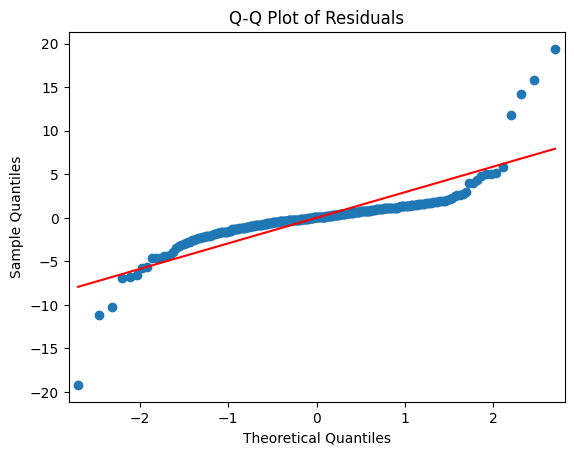

In [121]:
from statsmodels.formula.api import ols
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt


# Step 3: Build formula string
formula = 'Retail_Volume ~ ' + ' + '.join(test_a)

# Step 4: Fit OLS model
model_sm = ols(formula, data=reg_data).fit()
print(model_sm.summary())

# Step 5: Q-Q plot for residuals
sm.qqplot(model_sm.resid, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

### Permutation importance

In [117]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance


X = reg_data[selected_features]
y = reg_data['Retail_Volume']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression().fit(X_train, y_train)


result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)


importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importance_df)


  feature  importance_mean  importance_std
4    CBAR         0.041426        0.294316
1    LTIR         0.010488        0.011682
3     IIR         0.001744        0.025009
0     CPI        -0.004242        0.010075
2    STIR        -0.008074        0.044244
6   POP_y        -0.012420        0.041705
5   UEMPR        -0.017138        0.133193


In [118]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.2178 ± 0.4147,CBAR
0.0619 ± 0.3139,UEMPR
0.0029 ± 0.0303,LTIR
0.0018 ± 0.0791,POP_y
-0.0091 ± 0.0254,CPI
-0.0207 ± 0.0196,IIR
-0.0511 ± 0.0581,STIR


# **Causality**

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

def plot_granger_causality_pvalues(df, maxlag, variables, alpha=0.05, verbose=False):
    """
    Run grangercausalitytests and plot p-values for each lag.

    Parameters:
    - df: DataFrame with two columns [Y, X] where X is tested as a cause of Y
    - maxlag: maximum lag to test
    - variables: tuple (Y, X) – names of the dependent and independent variables
    - alpha: significance level for rejection
    - verbose: if True, prints full test output
    """
    y_col, x_col = variables
    test_result = grangercausalitytests(df[[y_col, x_col]], maxlag=maxlag, verbose=verbose)

    p_values = []
    for lag in range(1, maxlag + 1):
        p_val = test_result[lag][0]['ssr_ftest'][1]  # extract p-value from F-test
        p_values.append(p_val)

    # Plot p-values
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, maxlag + 1), p_values, color='skyblue')
    plt.axhline(y=alpha, color='red', linestyle='--', label=f'Significance level ({alpha})')
    plt.xticks(range(1, maxlag + 1))
    plt.xlabel("Lag")
    plt.ylabel("p-value")
    plt.title(f"Granger Causality Test p-values: Does {x_col} → {y_col}?")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return p_values


/Users/emirysaglam/GitHub/Bitirme2/.venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


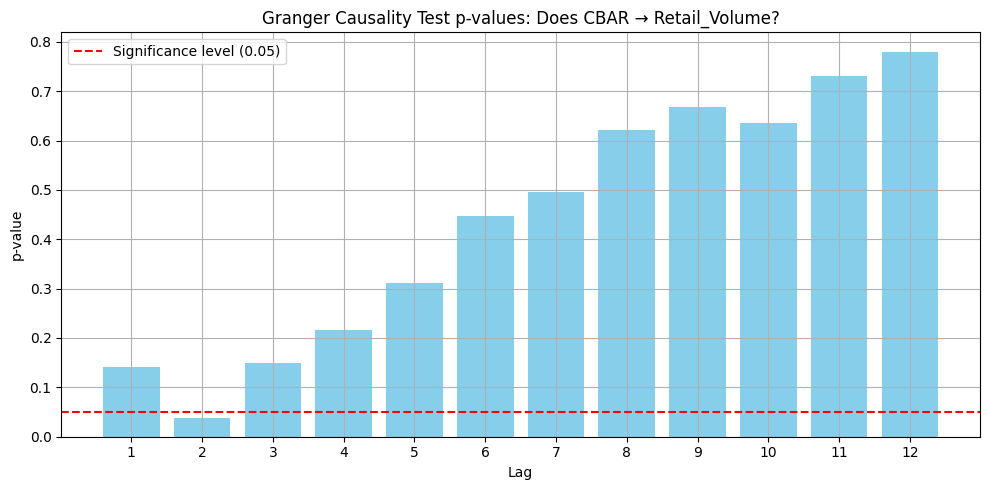

[np.float64(0.14181425757217755),
 np.float64(0.03734895445931497),
 np.float64(0.14917718928801924),
 np.float64(0.21586329923148484),
 np.float64(0.3107596338045549),
 np.float64(0.44740247198495475),
 np.float64(0.4947802887852),
 np.float64(0.6210143143879431),
 np.float64(0.6675990240363378),
 np.float64(0.6358087862976725),
 np.float64(0.7310689145358322),
 np.float64(0.7801036714892943)]

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

plot_granger_causality_pvalues(df_test, 12, variables=('Retail_Volume','CBAR'))


# **Cointegration**

In [ ]:
from statsmodels.tsa.stattools import coint

# Two time series: y and x (non-stationary)
# For example: y = GDP, x = Unemployment Rate
score, pvalue, _ = coint(df_test["Retail_Volume"],df_test["CBAR"])

print("Cointegration Test p-value:", pvalue)

if pvalue < 0.05:
    print("✅ Series are cointegrated.")
else:
    print("❌ No cointegration detected.")


Cointegration Test p-value: 1.03993061540743e-09
✅ Series are cointegrated.


In [ ]:
con.close()